# 과제 1

데이터셋에서 패턴, 유사성 또는 구조를 발견하여 데이터를 서로 다른 그룹으로 나누는 것을 의미한다. 그룹화는 데이터에 내재된 구조를 이해하고 도출하는 데 도움이 되며, 이러한 그룹은 일반적으로 유사한 특징이나 패턴을 공유하는 데이터 포인트들의 집합이다.

군집화(Clustering):
예시 모델: K-Means 군집화
설명: K-Means는 데이터를 K개의 클러스터로 나누는 알고리즘으로, 각 클러스터는 비슷한 특징을 가진 데이터 포인트들의 그룹입니다.

차원 축소(Dimensionality Reduction):
예시 모델: PCA (Principal Component Analysis)
설명: PCA는 데이터의 고유값과 고유벡터를 계산하여 이를 기반으로 주성분(Principal Components)을 추출합니다. 주성분은 데이터의 분산이 가장 큰 방향으로 정렬되어 있습니다. 주성분 중 일부만 선택하여 새로운 특징 공간으로 데이터를 투영함으로써 차원을 축소합니다.

# 과제 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/drive/MyDrive/Ybigta/0118 ML/실습 및 과제 데이터셋/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
# 결측치 없음
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
x1 = df.drop('Outcome', axis=1)
y = df['Outcome']

<Axes: >

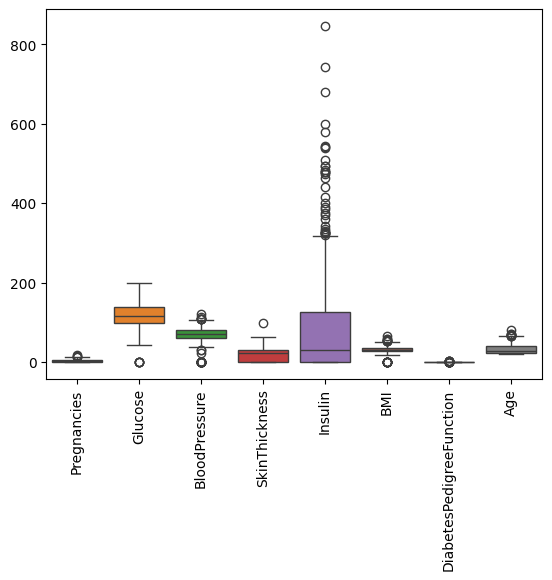

In [9]:
# 이상치 확인, 딱히 없는듯
plt.figure()
plt.xticks(rotation=90)
sns.boxplot(x1)

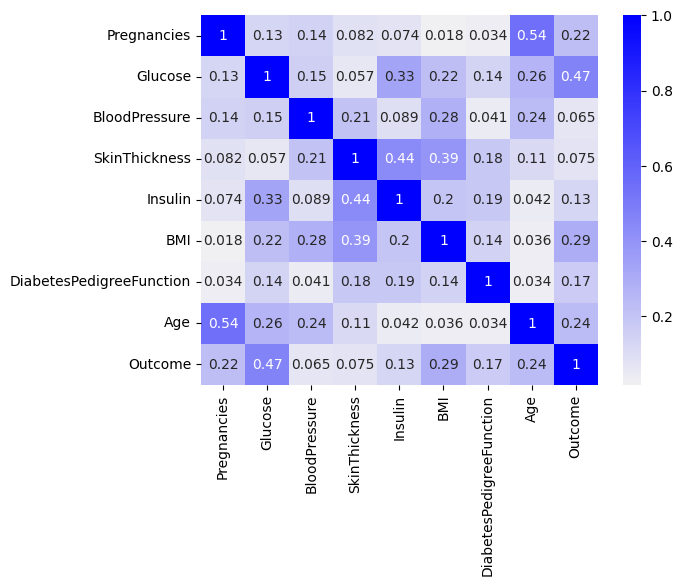

In [10]:
cmap = sns.light_palette(color="b", as_cmap=True)
sns.heatmap(df.corr().abs(), annot=True, cmap=cmap)
plt.show()

<Axes: xlabel='Outcome', ylabel='count'>

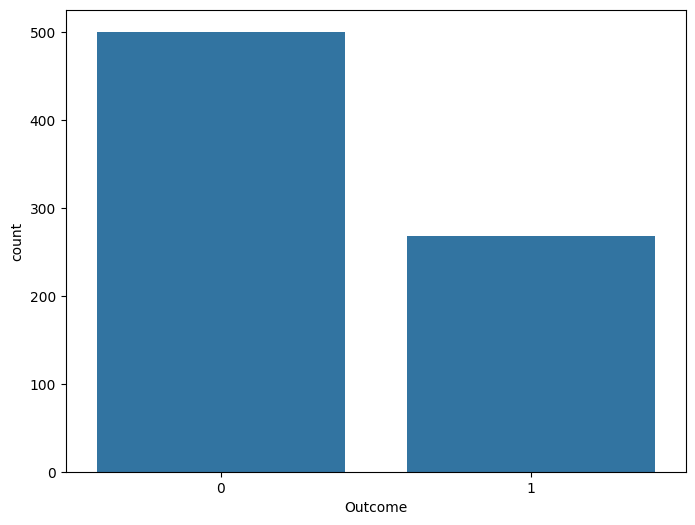

In [11]:
# class 불균형 여부 확인 -> 애매함
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Outcome')

In [12]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, shuffle=True, stratify=y, random_state=2019136025)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=2019136025)

In [13]:
# mRMR로 feature select하
k = 6
S = []

corr_matrix = (pd.concat([x_train, y_train], axis=1)
               .corr()
               .drop('Outcome'))

highest_corr_idx = np.argmax(corr_matrix['Outcome'])
first_feature = corr_matrix.index[highest_corr_idx]

S.append(first_feature)

for i in range(k - 1):
    relevance = np.abs(corr_matrix['Outcome'])
    redundancy = np.mean(np.abs(corr_matrix.loc[:, S]), axis=1)
    candidate_feature = (relevance - redundancy)
    candidate_feature = candidate_feature.drop(S)
    best_x_idx = np.argmax(candidate_feature)
    next_feature = candidate_feature.index[best_x_idx]
    S.append(next_feature)

# 선택된 특성 출력
print("Selected Features:", S)

Selected Features: ['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'Age', 'Insulin']


In [14]:
col_names = S
x2 = x1[col_names]
y = df['Outcome']

In [16]:
dt = DecisionTreeClassifier(random_state = 2019136025)
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=2019136025)

In [15]:
# 선택된 변수로들로의 데이터 재분할
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, shuffle=True, stratify=y, random_state=2019136025)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=2019136025)

In [18]:
# 검증 데이터 accuracy로 모델 평가
pred_y = dt.predict(x_val)
accuracy = accuracy_score(y_val, pred_y)
print(accuracy)

0.6585365853658537


In [19]:
param_grid = {
    'max_depth' : [None, 1, 5, 10, 50],
    'max_leaf_nodes' : [None, 2, 5, 10, 50],
    'max_features' : [None, 0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_split' : [0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_leaf' : [0.1, 0.3, 0.5, 0.7, 0.9]}

kf = KFold(n_splits=10, shuffle=True, random_state=2019136025)
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터와 그때의 accuracy 출력
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

Fitting 10 folds for each of 3750 candidates, totalling 37500 fits
Best Hyperparameters: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best Accuracy: 0.7555510204081632


In [20]:
# 최적의 하이퍼파라미터와 그때의 모델 얻기
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# 테스트 데이터에 최적의 모델 적용하여 정확도 계산
test_pred_y = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred_y)
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Test Accuracy: 0.7402597402597403
